In [1]:
! pip install kaggle

In [2]:
! pip install kagglehub

In [3]:
! pip install numpy
! pip install pandas
! pip install matplotlib

In [4]:
import numpy as np
import pandas as pd

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ahmeduzaki/global-earthquake-tsunami-risk-assessment-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\MVideo\.cache\kagglehub\datasets\ahmeduzaki\global-earthquake-tsunami-risk-assessment-dataset\versions\1


In [6]:
df = pd.read_csv(f"{path}/earthquake_data_tsunami.csv")

In [7]:
df.head()

,magnitude,cdi,mmi,sig,nst,dmin,gap,depth,latitude,longitude,Year,Month,tsunami
0,7.0,8,7,768,117,0.509,17.0,14.000,-9.7963,159.596,2022,11,1
1,6.9,4,4,735,99,2.229,34.0,25.000,-4.9559,100.738,2022,11,0
2,7.0,3,3,755,147,3.125,18.0,579.000,-20.0508,-178.346,2022,11,1
3,7.3,5,5,833,149,1.865,21.0,37.000,-19.2918,-172.129,2022,11,1
4,6.6,0,2,670,131,4.998,27.0,624.464,-25.5948,178.278,2022,11,1


В роли целеого класса я выберу класс tsunami так как он принимает только значения true, false, с чем удобнее работать, также я предполагаю, что этот параметр зависит от других

Сначала проверяю сбалансированность класса

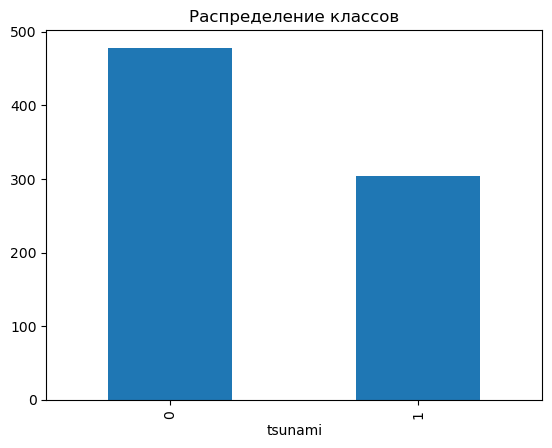

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
df['tsunami'].value_counts().plot(kind='bar')
plt.title('Распределение классов')
plt.show()

Он достаточно сбалансирован, а значит с ним можно работать

пусть x-параметры, а y-целевой аттрибут

In [16]:
y=df['tsunami']
x=df.drop('tsunami', axis=1)

Теперь разделим их на две части

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.3, random_state=13)

Сначала сделаем дерево решений

In [25]:
from sklearn.tree import DecisionTreeClassifier
first_tree = DecisionTreeClassifier(random_state=13)

Для дерева нужно найти хорошую максимальную глубину

In [27]:
from sklearn.model_selection import GridSearchCV

In [31]:
tree_params = {'max_depth': np.arange(1,11), 'max_features' : np.arange(0.2, 1, 0.1)}

In [32]:
tree_grid = GridSearchCV (first_tree, tree_params, cv=5, n_jobs=-1)

In [33]:
%%time
tree_grid.fit(x_train, y_train)

CPU times: total: 484 ms
Wall time: 4.8 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=13), n_jobs=-1,
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'max_features': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])})

Были найдены хорошие max_depth = 9 и max_features=0.8

In [36]:
tree_valid_pred = tree_grid.predict(x_valid)

In [37]:
tree_grid.score(x_valid, y_valid)

0.8468085106382979

то есть шанс успешного предсказывания оказался около 85%

Теперь время для kNN

In [43]:
from sklearn.neighbors import KNeighborsClassifier

In [44]:
first_knn=KNeighborsClassifier()

Найдём подходящее количество соседей

In [52]:
knn_params = {'n_neighbors': list(np.arange(1,10)) + list(np.arange(50,100,10))}

In [53]:
knn_grid = GridSearchCV(first_knn, knn_params, cv=5)

In [54]:
%%time
knn_grid.fit(x_train, y_train)

CPU times: total: 656 ms
Wall time: 676 ms


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 50, 60, 70,
                                         80, 90]})

In [55]:
knn_grid.best_params_

{'n_neighbors': 3}

то есть лучшее число соседей = 3

In [56]:
knn_valid_pred = knn_grid.predict(x_valid)

In [57]:
knn_grid.score(x_valid, y_valid)

0.8212765957446808

то есть шанс успешного предсказывания у knn оказался около 82%, что немного меньше, чем у дерева решений

Сравниваем полученные результаты с помощью различных метрик оценки качества:

Accurency

In [59]:
from sklearn.metrics import accuracy_score

In [63]:
accuracy_tree = accuracy_score(y_valid, tree_valid_pred)
print("Accuracy:", accuracy_tree)

Accuracy: 0.8468085106382979


In [64]:
accuracy_knn = accuracy_score(y_valid, knn_valid_pred)
print("Accuracy:", accuracy_knn)

Accuracy: 0.8212765957446808


получил те же самые значения что и до этого

Presicion

In [65]:
from sklearn.metrics import precision_score

In [66]:
precision_tree = precision_score(y_valid, tree_valid_pred)

In [67]:
print("Precision:", precision_tree)

Precision: 0.8210526315789474


In [68]:
precision_knn = precision_score(y_valid, knn_valid_pred)

In [69]:
print("Precision:", precision_knn)

Precision: 0.7894736842105263


Здесь значения в среднем стали меньше и разница между knn и деревом решений увеличилась

Recall

In [70]:
from sklearn.metrics import recall_score

In [71]:
recall_tree = recall_score(y_valid, tree_valid_pred)

In [72]:
print("Recall:", recall_tree)

Recall: 0.8041237113402062


In [73]:
recall_knn = recall_score(y_valid, knn_valid_pred)

In [74]:
print("Recall:", recall_knn)

Recall: 0.7731958762886598


F-measure

In [75]:
from sklearn.metrics import f1_score

In [77]:
Fmeasure_tree = f1_score(y_valid, tree_valid_pred)

In [78]:
print("Recall:", Fmeasure_tree)

Recall: 0.8125


In [79]:
Fmeasure_knn = f1_score(y_valid, knn_valid_pred)

In [80]:
print("Recall:", Fmeasure_knn)

Recall: 0.78125


В этих трех метриках оценки качества значения немного менялись, становясь то больше, то меньше, но дерево решений все равно имеет большее значение, чем knn

ROC

In [81]:
from sklearn.metrics import roc_curve, roc_auc_score

In [84]:
fpr, tpr, thresholds = roc_curve(y_valid, tree_valid_pred)
roc_auc = roc_auc_score(y_valid, tree_valid_pred)

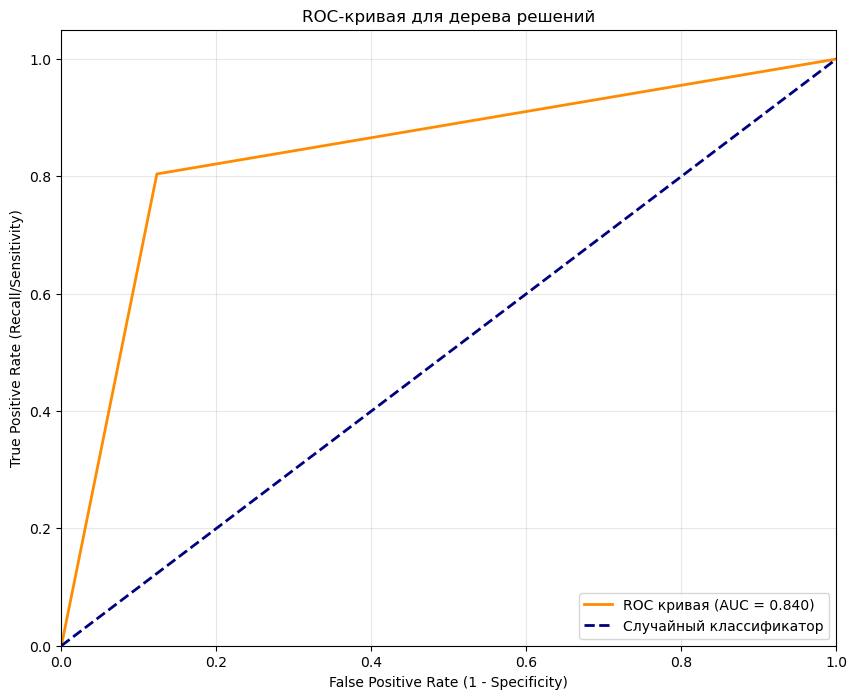

AUC-ROC: 0.8404676527715524


In [85]:
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC кривая (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Случайный классификатор')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Recall/Sensitivity)')
plt.title('ROC-кривая для дерева решений')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

print("AUC-ROC:", roc_auc)

In [86]:
fpr, tpr, thresholds = roc_curve(y_valid, knn_valid_pred)
roc_auc = roc_auc_score(y_valid, knn_valid_pred)

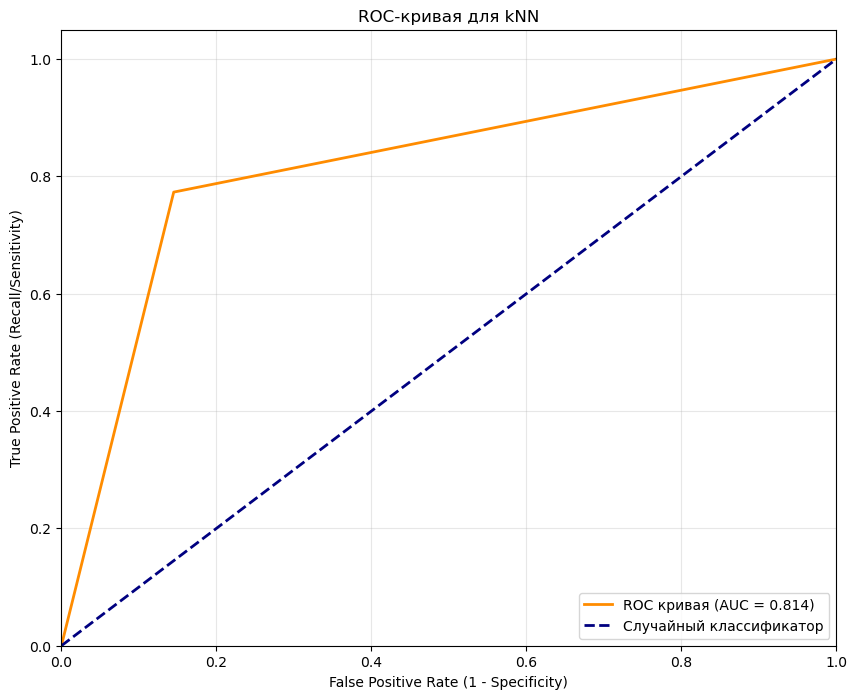

AUC-ROC: 0.814134170028388


In [87]:
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC кривая (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Случайный классификатор')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Recall/Sensitivity)')
plt.title('ROC-кривая для kNN')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

print("AUC-ROC:", roc_auc)

Здесь мы видим, что у kNN доля истинно-положительных ответов немного меньше, чем у дерева решений, что и следовало ожидать

Вывод: В моём случае дерево решений оказалось хоть и немного, но лучше, чем kNN, у разных метриках для оценки качества хоть и отличались значения, но показывали примерно одно и то же, что ожидаемо, ведь все они показывают эффективность модели.